# Project 2 QuantFund

#### Group members:
Ying LI 1155151488\
Ting Yuan LIN 1155148842\
Luofeng FENG 1155151520\
Anson Au-Yeung 1155148839

## Content
### Sample Selection
### 1. Regression
    1.1 Build the model
    1.2 Backtest simulation
### 2. Random Forest
    2.1 Build the model(Cross Validation)
    2.2 Backtest simulation
### 3. Support Vector Machine
    3.1 Build the model(Cross Validation)
    3.2 Backtest simulation
### 4. Trading Frequency
    4.1 One month
    4.2 Two days
### 5. Trading Feasibility
### 6. Differentiated Weight

In [1]:
import pandas as pd
import os
from scipy import stats
import numpy as np
from os import listdir
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn import linear_model

## Preparation: Calculate the forward returns for stocks and market indices

In [3]:
csv_path = "0 Data/"
stockclose = "StockClosePrice"
indexclose = "IndexClosePrice"

forward_day = 5 # this should depend on your rolling period

# calculate the forward returns
stock = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True)
stockforward = stock.shift(periods = -forward_day, freq = None, axis = 0)
# 5Dforward(t) = (close_price(t+5)-close_price(t))/close_price(t)
stockforwardreturn = (stockforward - stock) / stock
print(stockforwardreturn.head())
stockforwardreturn.to_csv(os.path.join(csv_path, '5DForward.csv')) #stock

# In the simulation, 
# you should also calculate indices returns, 
# and hedge your portfolio with any one of them.
index = pd.read_csv(csv_path + indexclose + ".csv", index_col = 0, parse_dates = True)
indexforward = index.shift(periods = -forward_day, freq = None, axis = 0)
indexforwardreturn = (indexforward - index) / index
print(indexforwardreturn.head())
indexforwardreturn.to_csv(os.path.join(csv_path, 'mkt_5DForward.csv')) #mkt

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2007-01-04   0.047482   0.061368   0.088638   0.186231   0.065688   0.122858   
2007-01-05   0.188363   0.084177   0.094316   0.107551  -0.016348   0.037043   
2007-01-08   0.219149   0.158273   0.103618   0.111985   0.006898   0.031495   
2007-01-09   0.233333   0.230769   0.096691   0.135329   0.075422   0.031128   
2007-01-10   0.208806   0.006994   0.083142   0.096759  -0.043272   0.007674   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2007-01-04   0.250000   0.125307        0.0   0.128390  ...        NaN   
2007-01-05   0.122891   0.073622        0.0   0.079454  ...        NaN   
2007-01-08   0.140277   0.086213        0.0   0.092567  ...        NaN   
2007-01-09   0.130120   0.044423        0.0   0.123708  ...        Na

## Read the factors

In [4]:
# Read all factor files
# You can select a sample of factors to shorten the running time
factor_folder = "0 Data/0 ALL_factors/"
factor_list = set(os.listdir(factor_folder)) - set(['.DS_Store'])
factor_list = list(factor_list)

# Remeber to Z-score the factor values to remove the scale differences
dfs = []
i = 0
for factor in factor_list:
    dfs.append(factor)
    df = pd.read_csv(factor_folder + factor , index_col = 0, parse_dates = True)
    dfs[i] = (df - df.mean()) / df.std() 
    i = i + 1

print(dfs[0].head())

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2008-01-02   0.874219  -0.572484  -0.323664  -0.678830  -0.612200  -0.015969   
2008-01-03   0.874219  -0.572484  -0.442974  -0.655338  -0.612200  -0.020221   
2008-01-04   0.878537  -0.589385  -0.576100  -0.655338  -0.537180  -0.020221   
2008-01-07   0.859824  -0.578449  -0.620056  -0.647820  -0.522176  -0.015969   
2008-01-08   0.325796  -0.578449  -0.620056  -0.647820  -0.522176  -0.015969   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2008-01-02  -0.189387  -0.457003   -0.09917  -0.321698  ...        NaN   
2008-01-03  -0.189387  -0.457003   -0.09917  -0.383249  ...        NaN   
2008-01-04  -0.058692  -0.351775   -0.09917  -0.364224  ...        NaN   
2008-01-07  -0.058692  -0.351775   -0.09917  -0.364224  ...        Na

## Re-organize the data

Here we need to re-organize the data for use. I build distinct dataframe for each stock and concat them all.

#### Note: Please feel free to rewrite the code for better efficiency.

In [5]:
#list all the factors
factors = ['return']
for i in range(len(factor_list)):
    factors.append(factor_list[i][:-4])

#match the data of return and factor
return_cut = stockforwardreturn[dfs[0].columns][dfs[0].index[0]:dfs[0].index[-1]]

## Training Factors: Linear Regression

I provide an example of how to train factors with linear regression, and how to re-organize the output into new dataframe for later backtesting.

In [ ]:
from sklearn import linear_model

#data = temp.dropna()

X = data.drop(['return'], axis=1)
Y = data['return']

model = linear_model.LinearRegression()
model.fit(X, Y)

yhat=data[['return']].copy()
yhat['return']=model.predict(X)

temp1=temp[['return']].join(yhat,lsuffix=1)[['return']]

for i in range(return_cut.shape[1]):
    if i == 0:
        factors_reg = temp1[0:return_cut.shape[0]]
        factors_reg.insert(0,'date',return_cut.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,temp2],axis=1)

factors_reg.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/0 new_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'Linear_Reg_factor.csv'))

## Backtesting Simulation

After saving the score in the same format as "Linear_Reg_factor.csv", You can directly run the following codes to see the backtesting simulation results. 

"helper.py" contains all formulas and plotting functions.

"backtestlite.py" contains the whole simulation process. 

You might need to look into them if you are targetting at the bonus questions.

### Linear Regression

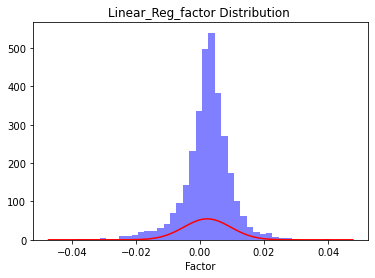

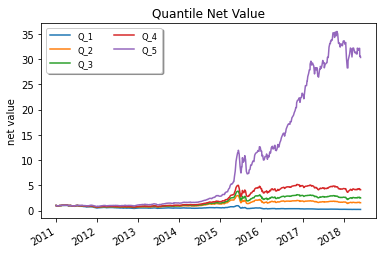

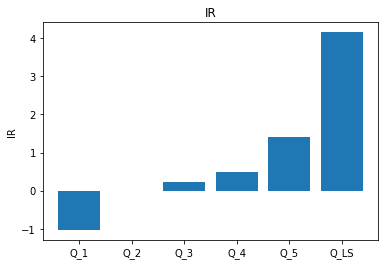

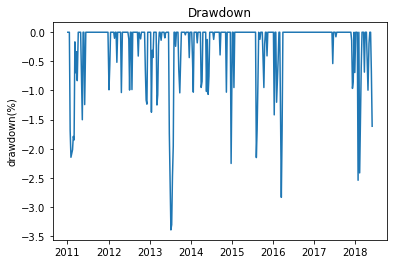

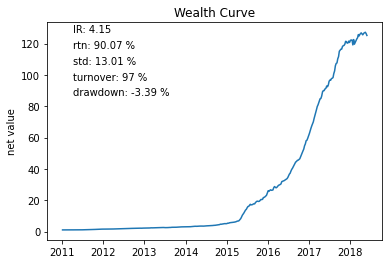

In [3]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "Linear_Reg_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

# Now, it's your turn !

## Use Machine Learning Models to construct new factors.


You should do a supervised learning with inputs being factor values, targets being stock returns. Try to use machine learning methods to construct a new synthetic factor which can better predict the stock performance. 

You should at least try Regressions, Support Vector Machine, Random Forests. 

In [6]:
temp=pd.read_csv("temp.csv", index_col=0)

### Deal with the missing value

We should drop the dates with no return value, and fitler out the factors with too many missing values.

In [6]:
data1 = temp.dropna(subset=['return'])

data1.isnull().sum()

# to balance the number of factors and the size of dataset, 
# drop the factors with missing value more that 10000000
# then drop the missing values for factors left
core_factors = data1.isnull().sum()[data1.isnull().sum()<1000000].index
data = data1[core_factors].dropna()
data

,return,TVMA6,RealizedVolatility,MoneyFlow20,ROE5,SalesCostRatio,LongTermDebtToAsset,PEHist60,DAVOL20,GainLossVarianceRatio20,InformationRatio60,ROAEBITTTM
index,,,,,,,,,,,,
"2,247",0.016418,-0.626250,-0.215174,-0.269442,2.803765,-1.089222,0.535918,0.130386,0.204384,-0.838437,0.573494,1.572421
"2,248",-0.047825,-0.581675,0.003336,-0.311837,2.803765,-1.089222,0.535918,0.323430,0.073483,-0.841472,0.615432,1.572421
"2,249",0.004374,-0.582662,0.015309,-0.372593,2.803765,-1.089222,0.535918,0.271810,-0.113519,-0.845172,0.443936,1.572421
"2,250",-0.007246,-0.594178,0.114087,-0.398948,2.803765,-1.089222,0.535918,0.305752,-0.207019,-0.826215,0.370544,1.572421
"2,251",0.004355,-0.611911,-0.185241,-0.423087,2.803765,-1.089222,0.535918,0.290903,-0.281820,-0.816737,0.058256,1.572421
...,...,...,...,...,...,...,...,...,...,...,...,...
"3569,2553",-0.057109,-0.564193,-0.166436,-0.419680,-1.619814,2.280919,-0.710949,-0.814628,0.498319,-0.057881,-0.039937,-1.233382
"3569,2554",-0.008637,-0.561983,-0.445162,-0.417579,-1.619814,2.280919,-0.710949,-0.956488,0.503022,-0.057860,-0.039937,-1.233382
"3569,2555",-0.020150,-0.555045,-0.250054,-0.410909,-1.619814,2.280919,-0.710949,-0.812719,0.514780,-0.057930,-0.039937,-1.233382


### Sample selection (reset the index)

We reset and split the index into stock and date. Then, we drop the trading date and choose 30% of the total data as the sample. 

In [7]:
# Reset index
data1 = data.reset_index() 
data1.head()

,index,return,TVMA6,RealizedVolatility,MoneyFlow20,ROE5,SalesCostRatio,LongTermDebtToAsset,PEHist60,DAVOL20,GainLossVarianceRatio20,InformationRatio60,ROAEBITTTM
0,"2,247",0.016418,-0.626250,-0.215174,-0.269442,2.803765,-1.089222,0.535918,0.130386,0.204384,-0.838437,0.573494,1.572421
1,"2,248",-0.047825,-0.581675,0.003336,-0.311837,2.803765,-1.089222,0.535918,0.323430,0.073483,-0.841472,0.615432,1.572421
2,"2,249",0.004374,-0.582662,0.015309,-0.372593,2.803765,-1.089222,0.535918,0.271810,-0.113519,-0.845172,0.443936,1.572421
3,"2,250",-0.007246,-0.594178,0.114087,-0.398948,2.803765,-1.089222,0.535918,0.305752,-0.207019,-0.826215,0.370544,1.572421
4,"2,251",0.004355,-0.611911,-0.185241,-0.423087,2.803765,-1.089222,0.535918,0.290903,-0.281820,-0.816737,0.058256,1.572421


In [8]:
# Split stock ID and trade date from index
stock = [] 
date = []
for i in trange(data1.shape[0]):
    stock.append(str(data1['index'][i]).split(',')[0])
    date.append(str(data1['index'][i]).split(',')[1])

100%|██████████| 4477699/4477699 [00:46<00:00, 96600.14it/s] 


In [11]:
data1['stock'] = stock
data1['date_num'] = date
data1.head()

,index,return,TVMA6,RealizedVolatility,MoneyFlow20,ROE5,SalesCostRatio,LongTermDebtToAsset,PEHist60,DAVOL20,GainLossVarianceRatio20,InformationRatio60,ROAEBITTTM,stock,date_num
0,"2,247",0.016418,-0.626250,-0.215174,-0.269442,2.803765,-1.089222,0.535918,0.130386,0.204384,-0.838437,0.573494,1.572421,2,247
1,"2,248",-0.047825,-0.581675,0.003336,-0.311837,2.803765,-1.089222,0.535918,0.323430,0.073483,-0.841472,0.615432,1.572421,2,248
2,"2,249",0.004374,-0.582662,0.015309,-0.372593,2.803765,-1.089222,0.535918,0.271810,-0.113519,-0.845172,0.443936,1.572421,2,249
3,"2,250",-0.007246,-0.594178,0.114087,-0.398948,2.803765,-1.089222,0.535918,0.305752,-0.207019,-0.826215,0.370544,1.572421,2,250
4,"2,251",0.004355,-0.611911,-0.185241,-0.423087,2.803765,-1.089222,0.535918,0.290903,-0.281820,-0.816737,0.058256,1.572421,2,251


In [10]:
data2 = data1.drop('index', axis=1)
y = data2['stock']
x = data2.drop('stock',axis=1)

In [12]:
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 66,test_size=0.3,stratify=y)

In [13]:
x_test.head()

,return,TVMA6,RealizedVolatility,MoneyFlow20,ROE5,SalesCostRatio,LongTermDebtToAsset,PEHist60,DAVOL20,GainLossVarianceRatio20,InformationRatio60,ROAEBITTTM,date_num
2135927,-0.079936,3.611405,-0.102981,2.318876,-0.165797,-0.121181,0.141602,0.044889,2.126250,-0.146293,-0.022793,0.728473,1850
3540398,-0.030892,0.675216,1.802811,0.039933,1.113426,0.096389,0.231327,0.627141,0.357314,5.502189,0.830960,0.393088,1406
415003,0.055390,-0.159115,-1.072665,-0.260504,-1.201116,0.703104,-0.896654,-0.099462,-0.570327,-0.386265,-0.362405,-1.137336,2005
3979377,0.001746,-0.368816,-0.569898,-0.614576,-1.240963,1.547346,0.984180,-0.627669,0.117794,2.032216,0.516255,-0.303544,1304
3873059,-0.077273,-0.876922,-0.837847,-0.885275,0.182954,0.310031,-0.105698,0.010236,-0.232883,2.094346,-1.153128,-1.785527,2400


In [14]:
sample = x_test.drop('date_num',axis=1) 
sample = sample.reset_index(drop=True)
sample.head()

,return,TVMA6,RealizedVolatility,MoneyFlow20,ROE5,SalesCostRatio,LongTermDebtToAsset,PEHist60,DAVOL20,GainLossVarianceRatio20,InformationRatio60,ROAEBITTTM
0,-0.079936,3.611405,-0.102981,2.318876,-0.165797,-0.121181,0.141602,0.044889,2.126250,-0.146293,-0.022793,0.728473
1,-0.030892,0.675216,1.802811,0.039933,1.113426,0.096389,0.231327,0.627141,0.357314,5.502189,0.830960,0.393088
2,0.055390,-0.159115,-1.072665,-0.260504,-1.201116,0.703104,-0.896654,-0.099462,-0.570327,-0.386265,-0.362405,-1.137336
3,0.001746,-0.368816,-0.569898,-0.614576,-1.240963,1.547346,0.984180,-0.627669,0.117794,2.032216,0.516255,-0.303544
4,-0.077273,-0.876922,-0.837847,-0.885275,0.182954,0.310031,-0.105698,0.010236,-0.232883,2.094346,-1.153128,-1.785527


In [15]:
# Save the file
sample.to_csv('temp_sample.csv')

## 1. Regression

Firstly, we use linear regression to construct the synthetic factor and get the result.

In [7]:
temp_sample = pd.read_csv('temp_sample.csv',index_col=0)
temp_sample.head()

,return,TVMA6,RealizedVolatility,MoneyFlow20,ROE5,SalesCostRatio,LongTermDebtToAsset,PEHist60,DAVOL20,GainLossVarianceRatio20,InformationRatio60,ROAEBITTTM
0,-0.022930,0.396015,-0.943348,0.171187,0.336491,1.758165,0.039951,0.061626,0.067688,-0.355415,-0.840193,0.249519
1,-0.019486,-0.594887,0.384486,-0.622492,-1.650779,1.130250,-0.756809,-0.021148,-0.040863,-0.270570,0.196331,0.030816
2,-0.047559,-0.553067,0.726955,-0.592925,-0.107500,1.575123,0.029354,0.525727,0.176961,0.093383,0.492136,-1.598281
3,0.018461,-0.490971,-0.395776,-0.348298,-0.364771,-1.009040,0.072451,0.028168,0.367487,-0.322695,-0.034182,-0.278126
4,0.023451,2.166092,1.500757,0.679974,-0.045092,0.103373,-0.173071,0.012129,0.538481,-0.702804,0.169395,0.540580


### 1.1 Build the model

We use the sample data to build and fit the regression model. We save the result in 'REG_factor.csv'.

In [19]:
X = data.drop(['return'], axis=1)
Y = data['return']

model = linear_model.LinearRegression()
model.fit(X, Y)

yhat=data[['return']].copy()
yhat['return']=model.predict(X)

temp1=temp[['return']].join(yhat,lsuffix=1)[['return']]

for i in range(return_cut.shape[1]):
    if i == 0:
        factors_reg = temp1[0:return_cut.shape[0]]
        factors_reg.insert(0,'date',return_cut.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,temp2],axis=1)

factors_reg.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/0 new_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'REG_factor.csv'))

### 1.2 Backtest simulation

After building the synthetic factor, we do backtest simulation to evaluate the actual trading outcomes. Because stock return of the factor in quantile 5 is the highest among five quantiles, we set the parameter "direction = Ascending".

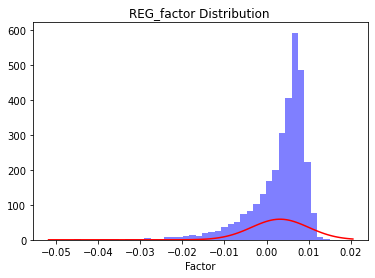

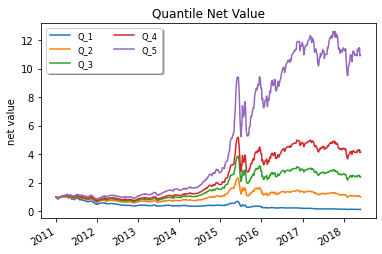

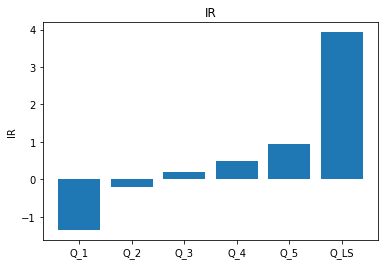

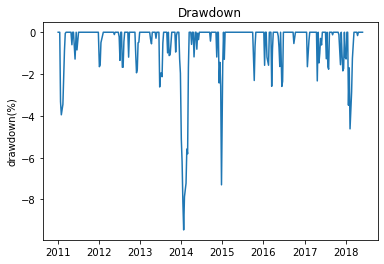

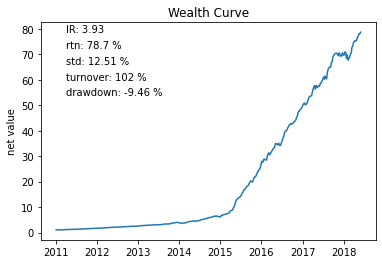

In [20]:
# Regression Backtest
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "REG_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

## 2.Random Forest

Secondly, we use Random Forests to construct a new synthetic factor and compare the result with linear regression to see whether it can better predict the stock performance. 

### 2.1 Build the model  (Cross Validation)

In order to find a better parameter, we use Cross Validation to solve underfitting or overfitting problems. Then, we use the best parameter among the range to fit the model and construct a new suynthetic factor. We save the result in 'RF_factor.csv'.

In [12]:
# Set two parameters - Cross Validation
param_grid = [
    {
    'max_depth':[10, 15, 20],
    'min_samples_leaf':[50, 60, 70]
    }
]
rfr = RandomForestRegressor(n_estimators=15, random_state=66) 
grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='neg_mean_squared_error',n_jobs = -1)

X = temp_sample.drop(['return'], axis=1)
Y = temp_sample['return']

grid_search.fit(X,Y)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=15, random_state=66),
             n_jobs=-1,
             param_grid=[{'max_depth': [10, 15, 20],
                          'min_samples_leaf': [50, 60, 70]}],
             scoring='neg_mean_squared_error')

In [14]:
# Find the best parameter
grid_search.best_params_

{'max_depth': 20, 'min_samples_leaf': 60}

In [16]:
# Fit the model and get the synthetic factor
X = temp_sample.drop(['return'], axis=1)
Y = temp_sample['return']
 
rfr = RandomForestRegressor(n_estimators = 15,
                            max_depth = 20,
                            min_samples_leaf = 60,
                            random_state = 66) 
rfr.fit(X,Y)

x = data.drop(['return'], axis=1)

yhat = data[['return']].copy()
yhat['return'] = rfr.predict(x)

temp1 = temp[['return']].join(yhat,lsuffix=1)[['return']]

for i in trange(return_cut.shape[1]):
    if i == 0:
        factors_rfr = temp1[0:return_cut.shape[0]]
        factors_rfr.insert(0,'date',return_cut.index)
        factors_rfr.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_rfr = pd.concat([factors_rfr,temp2],axis=1)

factors_rfr.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/0 new_factors/'
factors_rfr.to_csv(os.path.join(save_result_path, 'RF_factor.csv'))

100%|██████████████████████████████████████████████████████████████████████████████| 3569/3569 [02:51<00:00, 20.84it/s]


### 2.2 Backtest simulation

After building the factor by random forests, we do backtest simulation to evaluate the actual trading outcomes. Because stock return of the factor in quantile 5 is the highest among five quantiles, we can set the parameter "direction = Ascending".

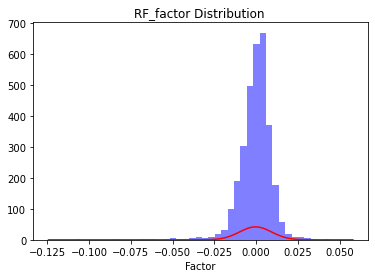

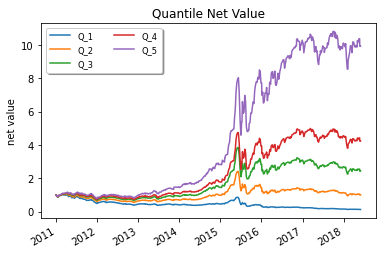

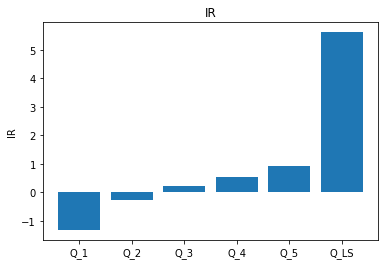

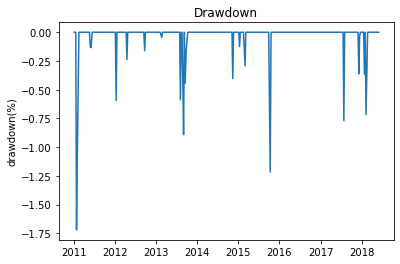

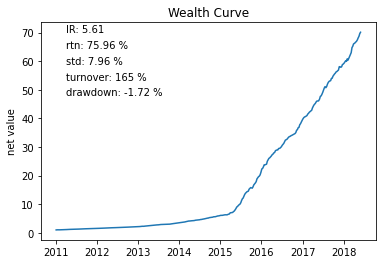

In [17]:
# Random Forest Backtest
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "RF_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

## 3. Support Vector Machine

Thirdly, we also use Support Vector Manchine to construct a new synthetic factor and compare the result with linear regression to see whether it can better predict the stock performance.

### 3.1 Build the model (Cross Validation)

In order to find a better parameter, we use Cross Validation to solve underfitting or overfitting problems. Then, we use the best parameter among the range to fit the model and construct a new suynthetic factor. We save the result in 'SVR_factor.csv'.
Due to time limit, we seperately run the five testing C value, then came out the result that when C=0.5, we will get the best result.

In [18]:
# Set one parameter - Cross Validation
param_grid = [
    {
        'kernel':['linear'],
        'C':[0.2, 0.5, 1, 2, 5]
    }
]
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error',n_jobs = -1)

X = temp_sample.drop(['return'], axis=1)
Y = temp_sample['return']

grid_search.fit(X,Y)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.5], 'kernel': ['linear']}],
             scoring='neg_mean_squared_error')

In [19]:
# Find the best parameter
grid_search.best_params_

{'C': 0.5, 'kernel': 'linear'}

In [18]:
# Fit the model and get the synthetic factor
X = temp_sample.drop(['return'], axis=1)
Y = temp_sample['return']

svr = SVR(kernel='linear',C = 0.5) 
svr.fit(X,Y)

x =data.drop(['return'], axis=1)

yhat = data[['return']].copy()
yhat['return'] = svr.predict(x)

temp1 = temp[['return']].join(yhat,lsuffix=1)[['return']]

for i in range(return_cut.shape[1]):
    if i == 0:
        factors_svr = temp1[0:return_cut.shape[0]]
        factors_svr.insert(0,'date',return_cut.index)
        factors_svr.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_svr = pd.concat([factors_svr,temp2],axis=1)

factors_svr.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/0 new_factors/'
factors_svr.to_csv(os.path.join(save_result_path, 'SVR_factor.csv'))

### 3.2 Backtest simulation

After building the factor by Support Vector Machine, we do backtest simulation to evaluate the actual trading outcomes. Because stock return of the factor in quantile 5 is the highest among five quantiles, we can set the parameter "direction = Ascending".

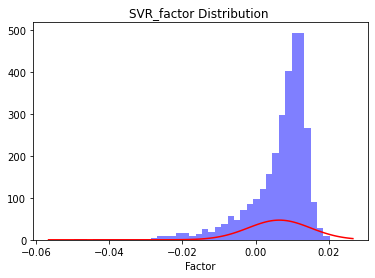

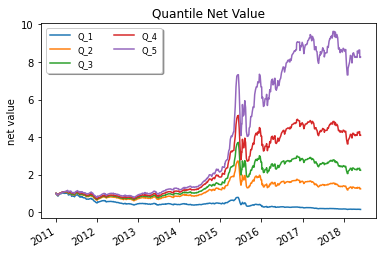

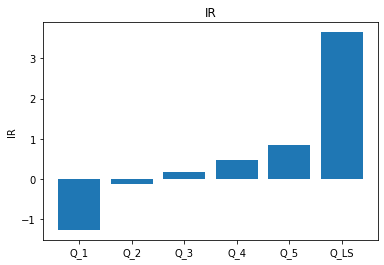

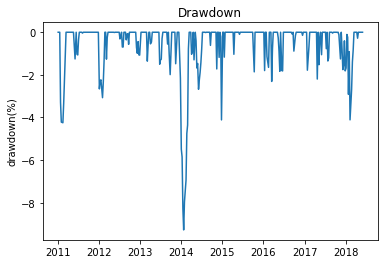

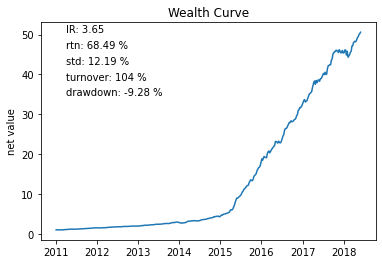

In [19]:
# SVM Backtest
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "SVR_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

From the backtest simulation of linear regression,random forest and support vector machine, we get REG_factor, RF_factor and SVR_factor.\
Compared three factors, we can find that the maximum drawdown of RF_factor is -1.72%, the smallest among three factors, which means that the biggest losses investors could face with is the smallest. As it shows in the wealth curve, the IR in random forests has the largest value, 5.61. This means that the RF_factor outperforms the broad market more consistently. Besides, RF_factor has the highest turnover rate, 165%.  It shows that the stocks in the random forests model are bought and sold frequently during the period.\
In conclusion, RF_factor can have the minimum risk level and get the best trading outcomes.

## 4.Trading Frequency

### 4.1 One month

We set trading frequency for one month, which contains roughly 21 trading days.\
We recalculate the stock forward return using forward_day = 21.\
For backtest result, we use linear regression model to compare two trading frequency.

In [2]:
csv_path = "0 Data/"
stockclose = "StockClosePrice"
indexclose = "IndexClosePrice"

forward_day = 21 # this should depend on your rolling period

# calculate the forward returns
stock = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True)
stockforward = stock.shift(periods = -forward_day, freq = None, axis = 0)
# 21Dforward(t) = (close_price(t+21)-close_price(t))/close_price(t)
stockforwardreturn = (stockforward - stock) / stock
print(stockforwardreturn.head())
stockforwardreturn.to_csv(os.path.join(csv_path, '21DForward.csv')) #stock

# In the simulation, 
# you should also calculate indices returns, 
# and hedge your portfolio with any one of them.
index = pd.read_csv(csv_path + indexclose + ".csv", index_col = 0, parse_dates = True)
indexforward = index.shift(periods = -forward_day, freq = None, axis = 0)
indexforwardreturn = (indexforward - index) / index
print(indexforwardreturn.head())
indexforwardreturn.to_csv(os.path.join(csv_path, 'mkt_21DForward.csv')) #mkt

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2007-01-04   0.243089  -0.068477   0.123149   0.198406  -0.182485   0.228794   
2007-01-05   0.277950  -0.010099   0.148890   0.191220  -0.195454   0.205770   
2007-01-08   0.310398  -0.045782   0.142167   0.173745  -0.193104   0.244073   
2007-01-09   0.333333  -0.015384   0.122606   0.150354  -0.198652   0.202357   
2007-01-10   0.356534  -0.107225   0.175763   0.096759  -0.215711   0.191577   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2007-01-04   0.317280   0.099292  -0.050273   0.155919  ...        NaN   
2007-01-05   0.323866   0.123503  -0.096812   0.207046  ...        NaN   
2007-01-08   0.317279   0.130531  -0.070742   0.215962  ...        NaN   
2007-01-09   0.321898   0.082190  -0.024203   0.177487  ...        Na

In [4]:
# Read all factor files
# You can select a sample of factors to shorten the running time
factor_folder = "0 Data/0 ALL_factors/"  
factor_list = set(os.listdir(factor_folder)) - set(['.DS_Store'])
factor_list = list(factor_list)

# Remeber to Z-score the factor values to remove the scale differences
dfs = []
i = 0
for factor in factor_list:
    dfs.append(factor)
    df = pd.read_csv(factor_folder + factor , index_col = 0, parse_dates = True)
    dfs[i] = (df - df.mean()) / df.std() 
    i = i + 1

print(dfs[0].head())

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2008-01-02   0.616604  -0.573801   0.367889  -0.412207  -0.128344   0.683501   
2008-01-03   0.636665  -0.556814   0.350072  -0.421300  -0.123676   0.497495   
2008-01-04   0.614573  -0.558603   0.371749  -0.414227  -0.131914   0.448408   
2008-01-07   0.596417  -0.564712   0.313548  -0.419279  -0.260702   0.442728   
2008-01-08   0.574071  -0.560093   0.335225  -0.398350  -0.233242   0.408651   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2008-01-02  -0.866557  -0.203887  -0.177084  -0.646319  ...        NaN   
2008-01-03  -0.878989  -0.194858  -0.177084  -0.661954  ...        NaN   
2008-01-04  -0.856763  -0.137074  -0.177084  -0.655143  ...        NaN   
2008-01-07  -0.846026  -0.112052  -0.177084  -0.666597  ...        Na

In [ ]:
#list all the factors
factors = ['return']
for i in range(len(factor_list)):
    factors.append(factor_list[i][:-4])

#match the data of return and factor
return_cut = stockforwardreturn[dfs[0].columns][dfs[0].index[0]:dfs[0].index[-1]]

#Construct each stock's dataset
data_trans=[]
for i in range(return_cut.shape[1]):
    temp = return_cut.iloc[:,i:i+1]
    data_trans.append(temp)
    for j in range(len(dfs)):
        temp = pd.concat([temp,dfs[j].iloc[:,i:i+1]],axis=1)
    temp.set_axis(factors, axis='columns', inplace=True)
    temp['index']=range(1,len(temp)+1)
    temp['index']=temp['index'].apply(lambda x:str(i+1)+','+str(x))
    temp.set_index(['index'],inplace=True)
    data_trans[i] = temp

#concat all the stock's data together
temp=data_trans[0].copy()

for i in range(1,len(data_trans)):
    temp = pd.concat([temp,data_trans[i]],axis=0)

temp.to_csv("0 Data/temp21D.csv")

In [ ]:
temp21D = pd.read_csv("0 Data/temp21D.csv", index_col=0)
#drop the redundant factors
factor_drop = ['TVMA20','PEHist120','FinancialExpenseRate','GainVariance120','NonOperatingNPTTM','GainLossVarianceRatio120','GREV','PBIndu','VEMA10','ILLIQUIDITY','SBM','PEHist250','Price1Y','STOM','SaleServiceRenderCashTTM','GainVariance20','EMA26','AD','DAREV','TVSTD20','PEIndu','SalesExpenseTTM','NonCurrentAssetsRatio','PCFIndu','SUE','MktValue','ATR14','InterestCover','GainLossVarianceRatio60','PSIndu','PE','InformationRatio120']
temp21D = temp21D.drop(factor_drop,axis=1)
temp21D.to_csv('0 Data/temp21D_del.csv')

In [7]:
temp21D = pd.read_csv("0 Data/temp21D_del.csv", index_col=0)
data21 = temp21D.dropna(subset=['return'])

data21.isnull().sum()

# to balance the number of factors and the size of dataset, 
# drop the factors with missing value more that 10000000
# then drop the missing values for factors left
core_factors = data21.isnull().sum()[data21.isnull().sum()<1000000].index
data21 = data21[core_factors].dropna()
data21

,return,LongTermDebtToAsset,PEHist60,DAVOL20,ROE5,InformationRatio60,SalesCostRatio,GainLossVarianceRatio20,RealizedVolatility,TVMA6,MoneyFlow20,ROAEBITTTM
index,,,,,,,,,,,,
"2,247",0.214925,0.535918,0.130386,0.204384,2.803765,0.573494,-1.089222,-0.838437,-0.215174,-0.626250,-0.269442,1.572421
"2,248",0.159420,0.535918,0.323430,0.073483,2.803765,0.615432,-1.089222,-0.841472,0.003336,-0.581675,-0.311837,1.572421
"2,249",0.183675,0.535918,0.271810,-0.113519,2.803765,0.443936,-1.089222,-0.845172,0.015309,-0.582662,-0.372593,1.572421
"2,250",0.239131,0.535918,0.305752,-0.207019,2.803765,0.370544,-1.089222,-0.826215,0.114087,-0.594178,-0.398948,1.572421
"2,251",0.235124,0.535918,0.290903,-0.281820,2.803765,0.058256,-1.089222,-0.816737,-0.185241,-0.611911,-0.423087,1.572421
...,...,...,...,...,...,...,...,...,...,...,...,...
"3569,2553",-0.023491,-0.710949,-0.814628,0.498319,-1.619814,-0.039937,2.280919,-0.057881,-0.166436,-0.564193,-0.419680,-1.233382
"3569,2554",0.017202,-0.710949,-0.956488,0.503022,-1.619814,-0.039937,2.280919,-0.057860,-0.445162,-0.561983,-0.417579,-1.233382
"3569,2555",-0.020150,-0.710949,-0.812719,0.514780,-1.619814,-0.039937,2.280919,-0.057930,-0.250054,-0.555045,-0.410909,-1.233382


In [ ]:
# Linear regression
X = data21.drop(['return'], axis=1)
Y = data21['return']

model = linear_model.LinearRegression()
model.fit(X, Y)

yhat=data21[['return']].copy()
yhat['return']=model.predict(X)

temp1=temp21D[['return']].join(yhat,lsuffix=1)[['return']]

for i in trange(return_cut.shape[1]):
    if i == 0:
        factors_reg = temp1[0:return_cut.shape[0]]
        factors_reg.insert(0,'date',return_cut.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,temp2],axis=1)

factors_reg.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/0 new_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'Linear_Reg_factor21.csv'))

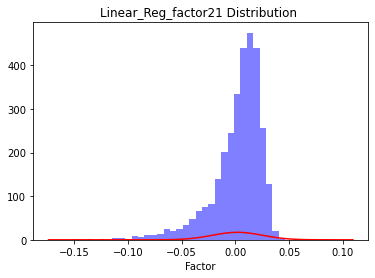

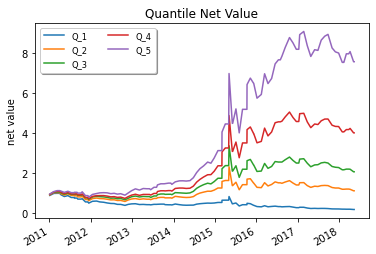

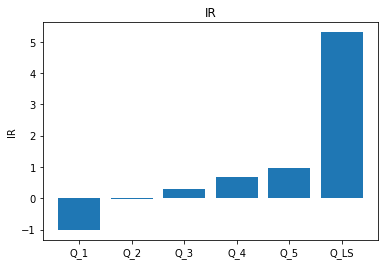

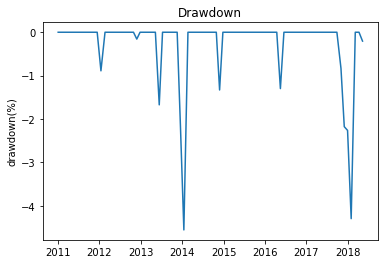

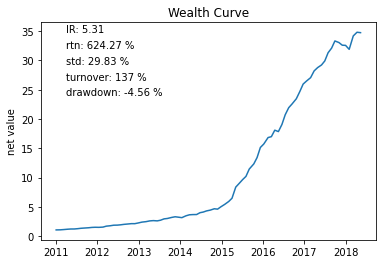

In [9]:
# Bactest Simulation
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 21   # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 21days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "21DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 21days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_21DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "Linear_Reg_factor21"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

Comparing with 5 days frequency(linear regression), the return performance of 21 days forward trading frequency is worse.

### 4.2 Two days

We set trading frequency for 2 trading days.\
We recalculate the stock forward return using forward_day = 2.\
For backtest result, we use linear regression model to compare two trading frequency.

In [2]:
csv_path = "0 Data/"
stockclose = "StockClosePrice"
indexclose = "IndexClosePrice"

forward_day = 2 # this should depend on your rolling period

# calculate the forward returns
stock = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True)
stockforward = stock.shift(periods = -forward_day, freq = None, axis = 0)
# 2Dforward(t) = (close_price(t+2)-close_price(t))/close_price(t)
stockforwardreturn = (stockforward - stock) / stock
print(stockforwardreturn.head())
stockforwardreturn.to_csv(os.path.join(csv_path, '2DForward.csv')) #stock

# In the simulation, 
# you should also calculate indices returns, 
# and hedge your portfolio with any one of them.
index = pd.read_csv(csv_path + indexclose + ".csv", index_col = 0, parse_dates = True)
indexforward = index.shift(periods = -forward_day, freq = None, axis = 0)
indexforwardreturn = (indexforward - index) / index
print(indexforwardreturn.head())
indexforwardreturn.to_csv(os.path.join(csv_path, 'mkt_2DForward.csv')) #mkt

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2007-01-04  -0.052447  -0.012274   0.022170   0.048580   0.058388   0.076282   
2007-01-05   0.056663   0.050506   0.052131   0.059746   0.055433   0.057599   
2007-01-08   0.053105   0.122301   0.014445   0.077229   0.035865   0.027552   
2007-01-09   0.071013   0.053205   0.042416   0.101488  -0.016834   0.031128   
2007-01-10   0.102272  -0.061771   0.047522  -0.003581  -0.078562  -0.034488   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2007-01-04   0.045641   0.014236        0.0   0.010995  ...        NaN   
2007-01-05   0.035443   0.068903        0.0   0.031398  ...        NaN   
2007-01-08   0.108067   0.069897        0.0   0.063537  ...        NaN   
2007-01-09   0.187220   0.057737        0.0   0.102148  ...        Na

In [3]:
# Read all factor files
# You can select a sample of factors to shorten the running time
factor_folder = "0 Data/0 ALL_factors/"  
factor_list = set(os.listdir(factor_folder)) - set(['.DS_Store'])
factor_list = list(factor_list)

# Remeber to Z-score the factor values to remove the scale differences
dfs = []
i = 0
for factor in factor_list:
    dfs.append(factor)
    df = pd.read_csv(factor_folder + factor , index_col = 0, parse_dates = True)
    dfs[i] = (df - df.mean()) / df.std() 
    i = i + 1

print(dfs[0].head())

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2008-01-02        NaN  -1.566509  -0.448055   3.746365  -1.731743   1.827469   
2008-01-03        NaN  -1.566509  -0.448055   3.746365  -1.731743   1.827469   
2008-01-04        NaN  -1.566509  -0.448055   3.746365  -1.731743   1.827469   
2008-01-07        NaN  -1.566509  -0.448055   3.746365  -1.731743   1.827469   
2008-01-08        NaN  -1.566509  -0.448055   3.746365  -1.731743   1.827469   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2008-01-02  -0.715609  -1.511073  -1.506714  -1.509512  ...        NaN   
2008-01-03  -0.715609  -1.511073  -1.506714  -1.509512  ...        NaN   
2008-01-04  -0.715609  -1.511073  -1.506714  -1.509512  ...        NaN   
2008-01-07  -0.715609  -1.511073  -1.506714  -1.509512  ...        Na

In [5]:
#list all the factors
factors = ['return']
for i in range(len(factor_list)):
    factors.append(factor_list[i][:-4])

#match the data of return and factor
return_cut = stockforwardreturn[dfs[0].columns][dfs[0].index[0]:dfs[0].index[-1]]

#Construct each stock's dataset
data_trans=[]
for i in trange(return_cut.shape[1]):
    temp = return_cut.iloc[:,i:i+1]
    data_trans.append(temp)
    for j in range(len(dfs)):
        temp = pd.concat([temp,dfs[j].iloc[:,i:i+1]],axis=1)
    temp.set_axis(factors, axis='columns', inplace=True)
    temp['index']=range(1,len(temp)+1)
    temp['index']=temp['index'].apply(lambda x:str(i+1)+','+str(x))
    temp.set_index(['index'],inplace=True)
    data_trans[i] = temp

#concat all the stock's data together
temp=data_trans[0].copy()

for i in trange(1,len(data_trans)):
    temp = pd.concat([temp,data_trans[i]],axis=0)
    
temp.to_csv("0 Data/temp2D.csv")

100%|██████████████████████████████████████████████████████████████████████████████| 3568/3568 [46:51<00:00,  1.27it/s]


In [4]:
#list all the factors
factors = ['return']
for i in range(len(factor_list)):
    factors.append(factor_list[i][:-4])

#match the data of return and factor
return_cut = stockforwardreturn[dfs[0].columns][dfs[0].index[0]:dfs[0].index[-1]]

In [5]:
temp2D = pd.read_csv("0 Data/temp2D.csv", index_col=0)
#drop the redundant factors
factor_drop = ['TVMA20','PEHist120','FinancialExpenseRate','GainVariance120','NonOperatingNPTTM','GainLossVarianceRatio120','GREV','PBIndu','VEMA10','ILLIQUIDITY','SBM','PEHist250','Price1Y','STOM','SaleServiceRenderCashTTM','GainVariance20','EMA26','AD','DAREV','TVSTD20','PEIndu','SalesExpenseTTM','NonCurrentAssetsRatio','PCFIndu','SUE','MktValue','ATR14','InterestCover','GainLossVarianceRatio60','PSIndu','PE','InformationRatio120']
temp2D = temp2D.drop(factor_drop,axis=1)
temp2D.to_csv('0 Data/temp2D_del.csv')

In [6]:
temp2D = pd.read_csv('0 Data/temp2D_del.csv',index_col=0)
data2D = temp2D.dropna(subset=['return'])

data2D.isnull().sum()

# to balance the number of factors and the size of dataset, 
# drop the factors with missing value more that 10000000
# then drop the missing values for factors left
core_factors = data2D.isnull().sum()[data2D.isnull().sum()<1000000].index
data2D = data2D[core_factors].dropna()
data2D

,return,MoneyFlow20,ROE5,ROAEBITTTM,DAVOL20,RealizedVolatility,SalesCostRatio,InformationRatio60,TVMA6,LongTermDebtToAsset,PEHist60,GainLossVarianceRatio20
index,,,,,,,,,,,,
"2,247",0.023880,-0.269442,2.803765,1.572421,0.204384,-0.215174,-1.089222,0.573494,-0.626250,0.535918,0.130386,-0.838437
"2,248",0.000000,-0.311837,2.803765,1.572421,0.073483,0.003336,-1.089222,0.615432,-0.581675,0.535918,0.323430,-0.841472
"2,249",0.004374,-0.372593,2.803765,1.572421,-0.113519,0.015309,-1.089222,0.443936,-0.582662,0.535918,0.271810,-0.845172
"2,250",-0.013043,-0.398948,2.803765,1.572421,-0.207019,0.114087,-1.089222,0.370544,-0.594178,0.535918,0.305752,-0.826215
"2,251",-0.046443,-0.423087,2.803765,1.572421,-0.281820,-0.185241,-1.089222,0.058256,-0.611911,0.535918,0.290903,-0.816737
...,...,...,...,...,...,...,...,...,...,...,...,...
"3569,2553",-0.001722,-0.419680,-1.619814,-1.233382,0.498319,-0.166436,2.280919,-0.039937,-0.564193,-0.710949,-0.814628,-0.057881
"3569,2554",0.013804,-0.417579,-1.619814,-1.233382,0.503022,-0.445162,2.280919,-0.039937,-0.561983,-0.710949,-0.956488,-0.057860
"3569,2555",-0.040301,-0.410909,-1.619814,-1.233382,0.514780,-0.250054,2.280919,-0.039937,-0.555045,-0.710949,-0.812719,-0.057930


In [7]:
# Linear regression
X = data2D.drop(['return'], axis=1)
Y = data2D['return']

model = linear_model.LinearRegression()
model.fit(X, Y)

yhat=data2D[['return']].copy()
yhat['return']=model.predict(X)

temp1=temp2D[['return']].join(yhat,lsuffix=1)[['return']]

for i in trange(return_cut.shape[1]):
    if i == 0:
        factors_reg = temp1[0:return_cut.shape[0]]
        factors_reg.insert(0,'date',return_cut.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,temp2],axis=1)

factors_reg.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/0 new_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'Linear_Reg_factor2.csv'))

100%|██████████████████████████████████████████████████████████████████████████████| 3569/3569 [02:40<00:00, 22.19it/s]


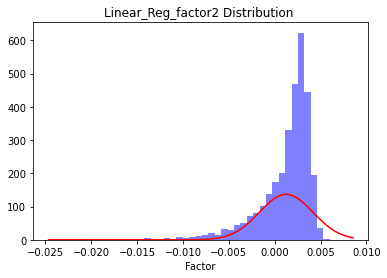

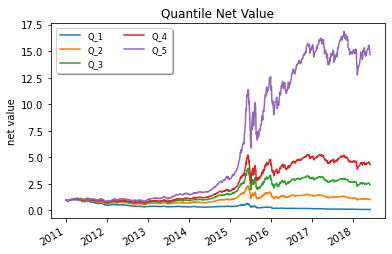

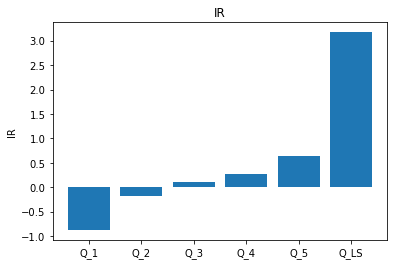

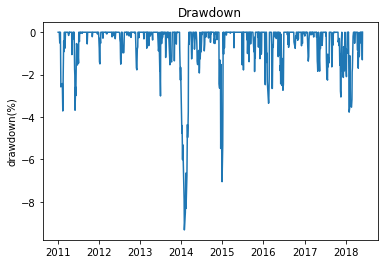

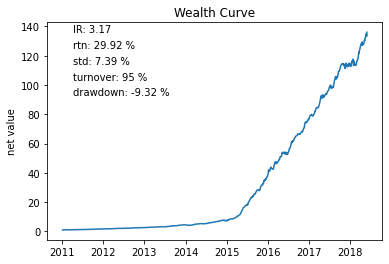

In [8]:
# Backtest simulation
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 2   # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 2days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "2DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 2days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_2DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "Linear_Reg_factor2"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

Comparing with 5 days trading frequency, net value of wealth curve increases for 2 days trading frequency.

## 5.Trading Feasibilty

We simply use the ratio of the price change between the opening price and the closing price of each stock on the day to select stock with benchmark equals to +10% or -10%. For stocks with a daily fluctuation of more than 10%, we will not trade it by assigning weight = 0.

In [9]:
csv_path = "0 Data/"
stockclose = "StockClosePrice"
stockopen = "StockOpenPrice"

stockopen = pd.read_csv(csv_path + stockopen + ".csv", index_col = 0, parse_dates = True)
stockclose = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True)

In [ ]:
#shift the stock close price down
#use (next date opening price - today close price)/today close price
stockclose1 = stockclose.shift(1)
stockclose1

In [12]:
stockfe = (stockopen - stockclose1) / stockclose1
stockfe

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,603987.SH,603988.SH,603989.SH,603990.SH,603991.SH,603993.SH,603996.SH,603997.SH,603998.SH,603999.SH
date,,,,,,,,,,,,,,,,,,,,,
2007-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,-0.012758,-0.011628,-0.012341,0.000000e+00,0.007293,0.000000,0.014400,0.000000,-1.000000e+00,-7.357804e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-08,-0.000764,-0.004713,0.004973,-4.019512e-03,-0.004264,0.000000,0.000000,0.000000,-1.000000e+00,-2.032148e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-09,0.001495,0.001962,-0.002415,3.857645e-03,-0.008274,0.000000,0.000000,0.006983,-1.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-10,-0.000726,0.012820,-0.009454,0.000000e+00,-0.008079,0.000000,-0.002317,0.024385,-1.000000e+00,3.633721e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-03,-0.001119,0.000468,-0.008574,3.341523e-03,-0.003669,-0.027243,-1.000000,0.002118,0.000000e+00,1.780301e-03,...,0.000000,-0.028502,-0.000967,-0.006913,-0.015655,-0.005570,1.185898e-16,-1.0,0.001547,0.000000
2018-08-06,0.003367,0.004744,0.000523,3.364005e-03,0.001821,-0.030120,-1.000000,-0.002120,4.536671e-03,0.000000e+00,...,0.003060,-0.015108,-0.011103,-0.016093,0.000000,-0.009541,-1.855836e-02,-1.0,-0.012556,0.000000
2018-08-07,0.002238,0.013902,0.000999,-1.199998e-16,0.005557,-0.004816,-0.100799,0.004349,1.505993e-16,-8.758439e-03,...,-0.003032,-0.026070,0.000000,-0.008072,0.000000,0.008373,1.516113e-02,-1.0,0.000000,0.009016


In [13]:
stockfe.to_csv('0 Data/stockfe.csv')
stockfe = pd.read_csv('0 Data/stockfe.csv')

In [14]:
for col in stockfe.columns[1:]:
    for i in range(2824):
        if abs(stockfe.loc[i,col]) > 0.1:
            stockfe.loc[i,col] = 0
        else:
            stockfe.loc[i,col] = 1
            
stockfe.to_csv('0 Data/stockfe_01.csv')

In [15]:
stockfe_01 = pd.read_csv('0 Data/stockfe_01.csv', index_col=0)
stockfe_01.head()

,date,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,603987.SH,603988.SH,603989.SH,603990.SH,603991.SH,603993.SH,603996.SH,603997.SH,603998.SH,603999.SH
0,2007-01-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2007-01-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2007-01-08,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2007-01-09,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2007-01-10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
stockfe_01.set_index(['date'],inplace=True)
stockfe_01

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,603987.SH,603988.SH,603989.SH,603990.SH,603991.SH,603993.SH,603996.SH,603997.SH,603998.SH,603999.SH
date,,,,,,,,,,,,,,,,,,,,,
2007-01-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2007-01-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2007-01-08,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2007-01-09,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2007-01-10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-03,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2018-08-06,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2018-08-07,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


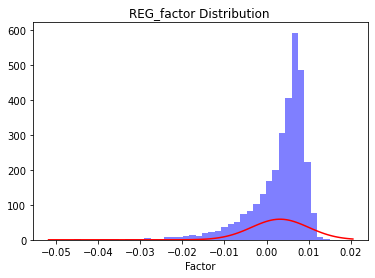

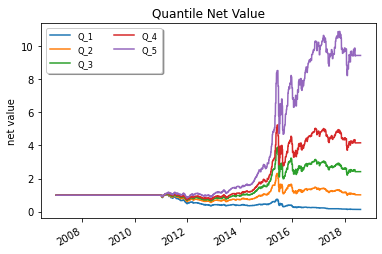

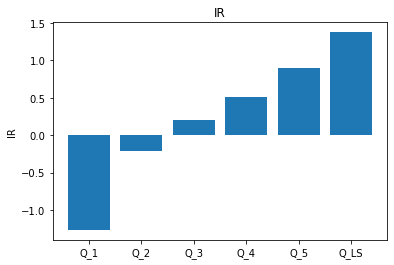

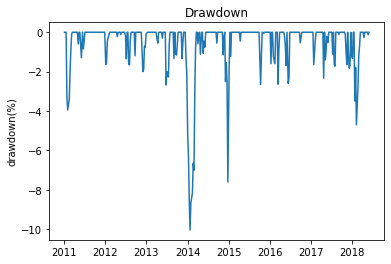

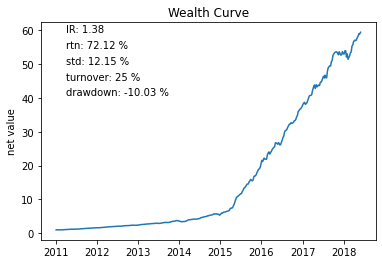

In [17]:
# Regression Backtest
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite_diff.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = stockfe_01

# Revise the factor name (name of .csv file)
factor =  "REG_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

## 6. Differentiated Weight

Instead of trading each share equally, we selected shares with relatively high return and low standard deviation (small fluctuation) by rewriting the 'backtestlite.py' file. For shares in quantile 3, 4 and 5, which have higher return compared with other quantiles, we divided original weight(=1) by its standard deviation then multiply it by the largest return ever, so that we give more weight for high return shares with small fluctuation. For shares in quantile 1 and 2, which have lower return following by lower risk, we assign weight to each share by multipling it original weight(=1) with its highest return ever, so that we put more weight on higher returns shares for those with lower risk/fluctuation.

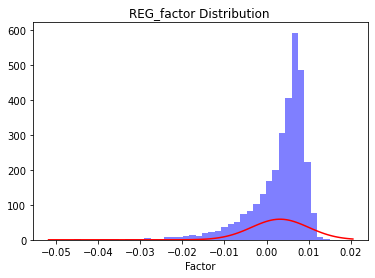

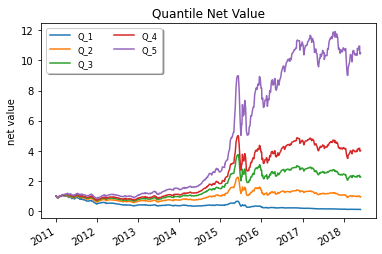

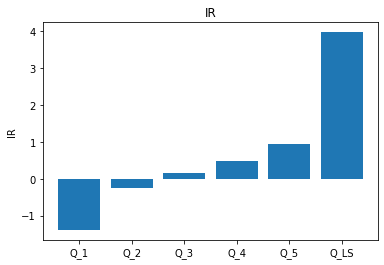

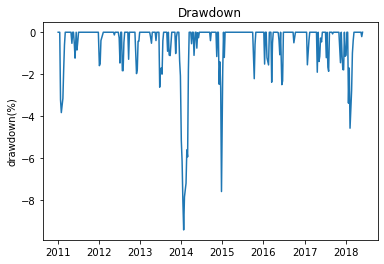

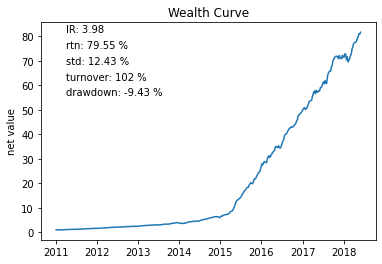

In [21]:
# Regression Backtest
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite_diff.py has XXX
%run -i "backtestlite_diff.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/0 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "REG_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

Compared with equal weighted trading strategy, we can observed from the 'Wealth Curve' that IR increase from 3.93 to 3.98, rtn increase from 78.7% to 79.55%, standard deviation decrease from 12.51% to 12.43%, and drawdown decrease from 9.46% to 9.43%.\
By adjusting the investment weight of each share, the overall rate of return has been slightly improved, and the range of risk fluctuations has also been reduced.